<a href="https://colab.research.google.com/github/shu-nya/Image-Classification-of-White-Blood-Cells/blob/master/WBC_Classification_with_VGG_and_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imblearn

In [2]:
import numpy as np
from keras.models import Sequential
from keras import applications
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
import csv
import cv2
import scipy
import os
from PIL import Image
#import splitfolders
import shutil

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_DIR = '/content/drive/MyDrive/taskMedPrime'

In [5]:
def get_data(folder):
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):

            for image_filename in os.listdir(folder + '/' + wbc_type):
                img_file = cv2.imread(folder + '/' + wbc_type + '/' + image_filename)

                if img_file is not None:
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(wbc_type)

    X = np.asarray(X)
    y = np.asarray(y)
    return X,y


In [6]:
X_train, y_train = get_data(BASE_DIR + '/train')
X_test, y_test = get_data(BASE_DIR + '/test')


In [7]:
X_train = X_train * 1./255.
X_test = X_test * 1./255.


In [8]:
y_train_unique_counts = np.unique(y_train, return_counts=True)

In [9]:
print(y_train_unique_counts)

(array(['bands', 'basophils', 'blasts', 'eosinophils', 'lymphocytes',
       'metamyelocytes', 'monocytes', 'myelocytes', 'neutrophils'],
      dtype='<U14'), array([103,  88,  85, 102, 234, 102, 106,  89, 250]))


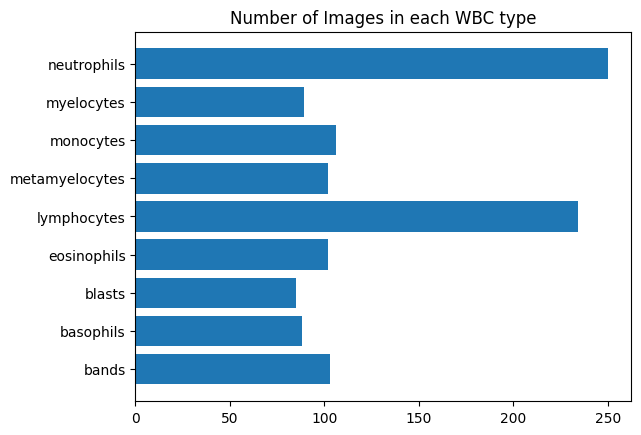

In [10]:
plt.title('Number of Images in each WBC type')
plt.barh(y_train_unique_counts[0], y_train_unique_counts[1])
plt.show()

In [11]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({'neutrophils': 250, 'lymphocytes': 234, 'monocytes': 106, 'bands': 103, 'eosinophils': 102, 'metamyelocytes': 102, 'myelocytes': 89, 'basophils': 88, 'blasts': 85})


In [12]:
# initialize the SMOTE model
#smote = SMOTE(random_state=62)
smote = SMOTE(k_neighbors=5, random_state=62)

# get all dimensions of the X
n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]

print(f"Shape of X_train before reshape: {X_train.shape}")

# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight)-type data
X_train_reshaped = X_train.reshape(n_samples, n_channels*height*width)

print(f"Shape of X_train after reshape: {X_train_reshaped.shape}")

Shape of X_train before reshape: (1159, 256, 256, 3)
Shape of X_train after reshape: (1159, 196608)


In [13]:
# perform re-sampling on modified X given y
X_smote, y_smote = smote.fit_resample(X_train_reshaped, y_train)

In [14]:
print(f'Before re-sampling, the number of images:  {len(X_train):6}')
print(f'After re-sampling, the number of images:{len(X_smote):10}')

Before re-sampling, the number of images:    1159
After re-sampling, the number of images:      2250


In [15]:
# summarize the new class distribution
counter = Counter(y_smote)
print(counter)

Counter({'bands': 250, 'basophils': 250, 'blasts': 250, 'eosinophils': 250, 'lymphocytes': 250, 'metamyelocytes': 250, 'monocytes': 250, 'myelocytes': 250, 'neutrophils': 250})


In [16]:
y_smote_unique_counts = np.unique(y_smote, return_counts=True)

In [17]:
print(y_smote_unique_counts)

(array(['bands', 'basophils', 'blasts', 'eosinophils', 'lymphocytes',
       'metamyelocytes', 'monocytes', 'myelocytes', 'neutrophils'],
      dtype='<U14'), array([250, 250, 250, 250, 250, 250, 250, 250, 250]))


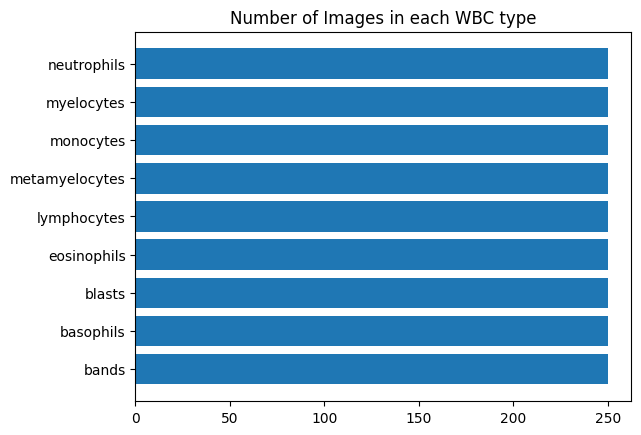

In [18]:
# view the resulting balanced data(modified distribution)
plt.title('Number of Images in each WBC type')
plt.barh(y_smote_unique_counts[0], y_smote_unique_counts[1])
plt.show()

In [19]:
X_train, y_train = X_smote, y_smote

In [20]:
n_samples, height, width, n_channels = 250*9, 256, 256, 3

In [21]:
X_train = X_train.reshape(n_samples, height, width, n_channels)

In [22]:
#Convert labels to one hot encoding

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)


In [23]:
from keras.models import Model
from keras.layers import Input
from keras import optimizers


In [24]:
num_classes = 9
epochs = 10
batch_size = 32


In [25]:
base_model = applications.VGG16(include_top=False, weights='imagenet')
input = Input(shape=(256, 256, 3), name = 'image_input')
vgg_output = base_model(input)

top_model = Flatten()(vgg_output)
top_model = Dense(64, activation='relu')(top_model)
predictions = Dense(num_classes, activation='softmax', name='prediction_layer')(top_model)

model = Model(inputs=input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
layers = base_model.layers[:-2]
for layer in layers:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [26]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 prediction_layer (Dense)    (None, 9)                 585       
                                                                 
Total params: 16,812,489
Trainable params: 4,457,609
Non-trainable params: 12,354,880
_________________________________________________________________


In [28]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True, verbose=1)


Epoch 1/10
57/57 [==============================] - 31s 266ms/step - loss: 2.5915 - accuracy: 0.4161 - val_loss: 1.5531 - val_accuracy: 0.4133
Epoch 2/10
57/57 [==============================] - 12s 207ms/step - loss: 0.7936 - accuracy: 0.7289 - val_loss: 3.0251 - val_accuracy: 0.1467
Epoch 3/10
57/57 [==============================] - 12s 210ms/step - loss: 0.4001 - accuracy: 0.8656 - val_loss: 1.5225 - val_accuracy: 0.4978
Epoch 4/10
57/57 [==============================] - 12s 214ms/step - loss: 0.1771 - accuracy: 0.9439 - val_loss: 2.5289 - val_accuracy: 0.3133
Epoch 5/10
57/57 [==============================] - 12s 216ms/step - loss: 0.1131 - accuracy: 0.9606 - val_loss: 2.2878 - val_accuracy: 0.4644
Epoch 6/10
57/57 [==============================] - 13s 222ms/step - loss: 0.0744 - accuracy: 0.9822 - val_loss: 0.8642 - val_accuracy: 0.7400
Epoch 7/10
57/57 [==============================] - 13s 220ms/step - loss: 0.0945 - accuracy: 0.9789 - val_loss: 0.6793 - val_accuracy: 0.8000

In [29]:
model.save_weights('vgg_top.h5')


In [30]:
model.load_weights('vgg_top.h5')


In [31]:
print('Predicting on test data')
#y_pred = np.rint(model.predict(X_test))

y_pred = model.predict(X_test)

print(y_pred)


Predicting on test data
7/7 [==============================] - 6s 880ms/step
[[6.22120023e-01 1.17738734e-08 2.43887189e-05 ... 1.11989175e-04
  3.18857114e-04 3.66061181e-01]
 [5.47855496e-01 1.03444819e-07 1.33363747e-08 ... 1.53541472e-02
  4.60014576e-07 3.47468197e-01]
 [3.66579513e-08 1.13443812e-21 5.18259120e-16 ... 1.85028520e-14
  2.73845716e-19 1.00000000e+00]
 ...
 [9.60616112e-01 9.63010461e-06 8.13466613e-06 ... 2.49265973e-02
  6.11268030e-03 4.58363589e-04]
 [3.60799646e-07 4.10819831e-15 3.52084750e-10 ... 5.76402272e-07
  2.71161687e-11 9.99978781e-01]
 [5.44172032e-08 1.69238870e-17 1.32665406e-10 ... 2.76447146e-11
  7.55351888e-17 9.99999881e-01]]


In [32]:
y_pred = np.rint(y_pred)

print(y_pred)


[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [33]:
from sklearn.metrics import accuracy_score


In [34]:
print(accuracy_score(y_test, y_pred))


0.7850467289719626


In [35]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 prediction_layer (Dense)    (None, 9)                 585       
                                                                 
Total params: 16,812,489
Trainable params: 4,457,609
Non-trainable params: 12,354,880
_________________________________________________________________


In [36]:
print(base_model.layers[-2].name)


block5_conv3


In [37]:
from sklearn.metrics import confusion_matrix

y_pred_unencoded = np.argmax(y_pred, axis=1)

y_test_unencoded = np.argmax(y_test, axis=1)

print(confusion_matrix(y_test_unencoded, y_pred_unencoded))


[[ 6  0  0  0  0  0  0  2  4]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  1]
 [ 0  0  0  5  0  4  0  0  1]
 [ 0  0  0  0 74  0  0  1  1]
 [ 1  1  0  0  1  0  2  1  4]
 [ 2  0  0  1  0  2  7  0  0]
 [ 0  0  0  0  4  0  0  0  0]
 [ 5  0  1  0  2  4  0  0 72]]
